# Calculating mismatches for axis-symmetric lenses

Here we calculate the mismatches with respect to different lens parameters for axially symmetric lens such as point mass and sis lens. We use the pycbc.filter package to calculate the matches. 

In [1]:
import numpy as np
import matplotlib.pyplot as pp
import pandas as pd
import heapq
import pycbc.waveform
from pycbc.types import FrequencySeries
%matplotlib inline
from pycbc.filter import match
from pycbc.psd import aLIGOZeroDetHighPower
import matplotlib as mpl
import time
import multiprocessing
from joblib import Parallel, delayed
from scipy.signal import find_peaks, find_peaks_cwt

pd.set_option('display.float_format', lambda x: '%.3e' % x)
plotdirName = "/Users/saifali/Desktop/gwlensing/plots/"

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from matplotlib.ticker import StrMethodFormatter, NullFormatter
from matplotlib.ticker import MaxNLocator
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.size'] = 25
mpl.rcParams['legend.handlelength'] = 3.0
mpl.rcParams['axes.linewidth'] = 1.0
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.major.width'] = 1.0
mpl.rcParams['xtick.minor.width'] = 1.0
mpl.rcParams['xtick.major.size'] = 5.0
mpl.rcParams['xtick.minor.size'] = 3.0
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['ytick.major.width'] = 1.0
mpl.rcParams['ytick.minor.width'] = 1.0
mpl.rcParams['ytick.major.size'] = 5.0
mpl.rcParams['ytick.minor.size'] = 3.0
mpl.rcParams['ytick.right'] = True

plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = '\\usepackage{sfmath}'

In [3]:
def unlensed_waveform(**args):
    
    theta_s = args['theta_s']
    phi_s = args['phi_s']
    theta_l = args['theta_l']
    phi_l = args['phi_l']
    mcz = args['mcz']
    dist = args['dist']
    eta = args['eta']
    tc = args['tc']
    phi_c = args['phi_c']
    flow = args['f_lower']
    
    df = args['delta_f']
    
    def limit(mcz, eta):
        low_limit = 20
        f_cut = 1 / (np.power(6, 3/2) * np.pi * ((mcz) / (np.power(eta, 3/5))))
        return low_limit, f_cut
    
    f = np.arange(flow, limit(mcz, eta)[1], df)
    #print(limit(mcz, eta)[1])
    """
    This file is just functionized form of L_unlensed(which was "object-oriented"). This was mainly created
    for the optimization of overlap function.
    """
    def mass_conv(mcz, eta):
        """Converts chirp mass to total mass. M = mcz/eta^(3/5)
        """

        M_val = mcz/np.power(eta, 3/5)
        return M_val

    def l_dot_n(theta_s, theta_l, phi_s, phi_l):
        """TODO
        """

        cos_term = np.cos(theta_s) * np.cos(theta_l)
        sin_term = np.sin(theta_s) * np.sin(theta_l) * np.cos(phi_s - phi_l)

        inner_prod = cos_term + sin_term
        return inner_prod

    def amp(mcz, dist):
        """TODO
        """

        amplitude = np.sqrt(5 / 96) * np.power(np.pi, -2 / 3) * np.power(mcz, 5 / 6) / (dist)
        return amplitude

    def psi(f, tc, phi_c, mcz, eta):
        """eqn 3.13 in Cutler-Flanaghan 1994
        """

        front_terms = 2 * np.pi * f * tc - phi_c - np.pi / 4
        main_coeffs = 0.75 * np.power(8 * np.pi * mcz * f, -5 / 3)
        main_terms = (1 + 20 / 9 * (743 / 336 + 11 / 4 * eta) * np.power(np.pi * mass_conv(mcz, eta) * f, 2 / 3)
                        - (16 * np.pi) * np.power(np.pi * mass_conv(mcz, eta) * f, 1))

        psi_val = front_terms + main_coeffs * (main_terms)
        return psi_val

    def psi_s(theta_s, theta_l, phi_s, phi_l):

        numerator = np.cos(theta_l)-np.cos(theta_s)*(l_dot_n(theta_s, theta_l, phi_s, phi_l))
        denominator = np.sin(theta_s)*np.sin(theta_l)*np.sin(phi_l-phi_s)

        psi_s_val = np.arctan2(numerator, denominator)
        return psi_s_val


    def fIp(theta_s, phi_s):
        """TODO
        """

        term_1 = (1 / 2 * (1 + np.power(np.cos(theta_s), 2)) * np.cos(2*phi_s)* np.cos(2*psi_s(theta_s, theta_l, phi_s, phi_l)))
        term_2 = (np.cos(theta_s) * np.sin(2*phi_s)* np.sin(2*psi_s(theta_s, theta_l, phi_s, phi_l)))

        fIp_val = term_1 - term_2
        return fIp_val

    def fIc(theta_s, phi_s):
        """TODO
        """

        term_1 = (1 / 2 * (1 + np.power(np.cos(theta_s), 2)) * np.cos(2*phi_s)
                    * np.sin(2*psi_s(theta_s, theta_l, phi_s, phi_l)))
        term_2 = (np.cos(theta_s) * np.sin(2*phi_s)
                    * np.cos(2*psi_s(theta_s, theta_l, phi_s, phi_l)))

        fIc_val = term_1 + term_2
        return fIc_val

    def lambdaI():
        """TODO
        """

        term_1 = np.power(2 * l_dot_n(theta_s, theta_l, phi_s, phi_l) * fIc(theta_s, phi_s), 2)
        term_2 = np.power((1 + np.power(l_dot_n(theta_s, theta_l, phi_s, phi_l), 2)) * fIp(theta_s, phi_s), 2)

        lambdaI_val = np.sqrt(term_1 + term_2)
        return lambdaI_val

    def phi_pI():
        """TODO
        """

        numerator = (2 * l_dot_n(theta_s, theta_l, phi_s, phi_l) * fIc(theta_s, phi_s))
        denominator = ((1 + np.power(l_dot_n(theta_s, theta_l, phi_s, phi_l), 2)) * fIp(theta_s, phi_s))

        phi_pI_val = np.arctan2(numerator, denominator)
        return phi_pI_val

    term_1 = lambdaI()
    term_2 = (np.exp(-1j * phi_pI()))
    term_3 = amp(mcz, dist) * np.power(f, -7 / 6)
    term_4 = np.exp(1j * psi(f, tc, phi_c, mcz, eta))

    signal_I = term_1 * term_2 * term_3 * term_4
    
    signal_I = FrequencySeries(signal_I, delta_f = df)
    return signal_I, f

In [4]:
pycbc.waveform.add_custom_waveform('unlensed', unlensed_waveform, 'frequency', force=True)

In [5]:
solar_mass = 4.92624076 * 10**-6 #[solar_mass] = sec
giga_parsec = 1.02927125 * 10**17 #[giga_parsec] = sec

hf, freq_arr = pycbc.waveform.get_fd_waveform(approximant="unlensed",
                                        theta_s = 0, phi_s = 0, theta_l = 0, phi_l = 0, 
                                        mcz = 20 * solar_mass, dist = 1 * giga_parsec, eta = 0.25,
                                        tc = 0, phi_c = 0,
                                        delta_f=1/4, f_lower = 20)

In [6]:
def Sn(f):
        """From table 1 of arXiv:0903.0338. Changed from iLIGO to aLIGO.
        """
        fs = 20
        if f < fs:
            Sn_val = np.inf
        else:
            S0 = 1E-49
            f0 = 215
            Sn_temp = np.power(f/f0, -4.14) - 5 * np.power(f/f0, -2) + 111 * ((1 - np.power(f/f0, 2) + 0.5 * np.power(f/f0, 4)) / (1 + 0.5 * np.power(f/f0, 2)))
            Sn_val = Sn_temp * S0

        return Sn_val
    
psd_analytical = np.zeros_like(freq_arr)
for i in range(len(freq_arr)):
    psd_analytical[i] = Sn(freq_arr[i])
psd_analytical = FrequencySeries(psd_analytical, delta_f = 1/4)
#pp.loglog(freq_arr, psd_analytical)

In [7]:
def magnification(y, ML, lens = 'sis'):
    
        if lens == 'pm':
            mu_plus = np.abs(0.5 + (y ** 2 + 2) / (2 * y * (y ** 2 + 4) ** 0.5))
            mu_minus = np.abs(0.5 - (y ** 2 + 2) / (2 * y * (y ** 2 + 4) ** 0.5))
        
        elif lens == 'sis':
            mu_plus = np.abs(1 + 1 / y)
            mu_minus = np.abs(-1 + 1 / y)
        
        return mu_minus / mu_plus, mu_plus, mu_minus

def time_del(y, ML, lens = 'sis'):

    if lens == 'pm':
        first_term = (y * (y ** 2 + 4) ** 0.5) / 2
        second_term = np.log(((y ** 2 + 4) ** 0.5 + y) / ((y ** 2 + 4) ** 0.5 - y))
        tds = 4 * ML * (first_term + second_term)

    elif lens == 'sis':
        tds = 8 * ML * y

    return tds
magnification(0.5, 1e4 * solar_mass, 'sis'), time_del(0.5, 1e4 * solar_mass, 'sis')

((0.3333333333333333, 3.0, 1.0), 0.19704963039999995)

In [8]:
from mpmath import *
def amp_fact_sis_wo(y, ML, f = freq_arr):
        '''computes the amplification factor for source SIS lens.
        Parameters
        ----------
        f : array
            frequency
        y : float
            source position
        Return
        ----------
        F_val : array, complex
            Amplification factor for SIS
        '''
        F_val_sis = np.zeros_like(f, dtype = np.complex128)
        for i in range(len(f)):
            w = 8 * pi * ML * f[i]
            pre_factor = exp(1j * (w / 2) * (y**2 + 2 * (y + 0.5)))
            func = lambda n: (gamma(1 + n / 2) / fac(n)) * (2 * w * exp(1j * 3 * (pi / 2))) ** (n / 2) * hyp1f1(1 + n / 2, 1, -1j * (w / 2) * y ** 2)
            series_sum = nsum(func, [0, inf])

            F_val_sis[i] = np.complex128(pre_factor * series_sum, dtype = np.complex128)

        return F_val_sis

In [9]:
def amp_fact_sis_go(y, ML, f = freq_arr):
        '''computes the amplification factor for source SIS lens in the geometrical optics limit.

        Parameters
        ----------
        f : array
            frequency

        y : float
            source position

        Return
        ----------
        F_val : array, complex
            Amplification factor for SIS
        '''
        td = time_del(y, ML)
        mu_plus = magnification(y, ML)[1]
        mu_minus = magnification(y, ML)[2]
        if y <= 1:
            F_val_sis = np.sqrt(np.abs(mu_plus)) - 1j * np.sqrt(np.abs(mu_minus)) * np.exp(2 * np.pi * 1j * f * td)
        else:
            F_val_sis = np.sqrt(np.abs(mu_plus))  
    
        return F_val_sis

In [10]:
def get_f_transition(y, ML):
        """ Calculate the frequency (f_transition) after which geometrical optics is valid
        """
        freq_range = np.logspace(np.log10(0.001), np.log10(250), 200)
        Fsis_series = np.abs(amp_fact_sis_wo(y, ML, freq_range)) 
        peaks, _ = find_peaks(Fsis_series) 
        
        return freq_range[peaks][0]
    
f_trans = get_f_transition(0.5, 1e4 * solar_mass)
td = time_del(0.5, 1e4 * solar_mass, 'sis')

f_trans, td, f_trans * td

(1.5877734948023565, 0.19704963039999995, 0.3128701803097206)

In [11]:
def pycbc_match(y, ML, hf = hf):
    
    hf_lensed_source = hf * amp_fact_sis_wo(y, ML)
    pycbc_match = match(hf_lensed_source, hf, psd=psd_analytical, low_frequency_cutoff=20)[0]
    
    return pycbc_match

In [60]:
start = time.time()
num_pts = 25
y_range = np.linspace(0.1, 1, num_pts)
ML_range = np.linspace(1e1 * solar_mass, 3e3 * solar_mass, num_pts)
y_mesh, ML_mesh = np.meshgrid(y_range, ML_range)
y_range = y_mesh.flatten()
ML_range = ML_mesh.flatten()
match_range = np.zeros_like(ML_range)

for i in range(len(ML_range)):
    match_range[i] = pycbc_match(y_range[i], ML_range[i])
    #print(y_range[i], ML_range[i] / solar_mass, match_range[i])
end = time.time()
print(f'elapsed time: {(end - start) / 60}')

elapsed time: 146.7030253648758


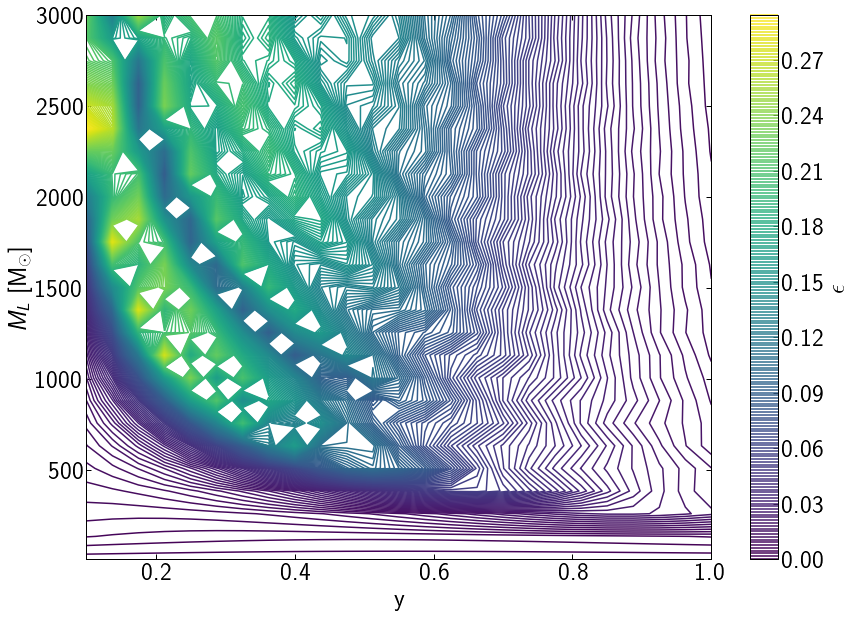

In [67]:
y_mesh = y_range.reshape(num_pts, num_pts)
ML_mesh = ML_range.reshape(num_pts, num_pts)
mismatch_range = 1 - np.array(match_range)
mismatch_mesh = mismatch_range.reshape(num_pts, num_pts)
snr_min_range = 1 / np.sqrt(mismatch_range)
snr_min_mesh = snr_min_range.reshape(num_pts, num_pts)

# norm = mpl.colors.Normalize(vmin=np.min(ML_mesh),vmax=np.max(ML_mesh))
# c_m = mpl.cm.summer
# s_m = mpl.cm.ScalarMappable(cmap=c_m, norm=norm)
fig,ax=plt.subplots(1,1, figsize = (14, 10))
cp = plt.contourf(y_mesh, ML_mesh / solar_mass, mismatch_mesh, levels = 200)
ax.set_xlabel('y', fontsize = 25)
ax.set_ylabel(r'$M_L$ $[\mathrm{M}_\odot]$', fontsize = 25)
ax.tick_params(axis='both', which='both', direction='in', labelsize=25)

cbar = fig.colorbar(cp)
cbar.set_label(r'$\epsilon$', fontsize=25)
cbar.ax.tick_params(direction='in',labelsize=25)

#plt.savefig('contour_plot_y_ML_3e3_625pts.png', dpi = 500, bbox_inches = 'tight')

In [56]:
data = pd.DataFrame({'y_range': y_range,
                    'ML_range': ML_range,
                    'miismatch_range': mismatch_range})
data.to_csv('/Users/saifali/Desktop/gwlensing/data/pycbc_match_sis.csv', index = False)

In [ ]:
plt.figure(figsize = (10, 8))
#td_sis = time_del(y, ML_range)
#print(len(td_sis))
mismatch_th = 1 - (1 / np.sqrt(1 + magnification(0.8, 1e2 * solar_mass)[0]))
fig, axs = plt.subplots(figsize = (8, 6))
axs.plot(ML_range / solar_mass, 1 - match_range)
#axs.axhline(mismatch_th, ls = '-.', color = 'red', label = 'mismatch saturation in GO regime')
#axs.axvline(0.05 / (8 * y * solar_mass), ls = '--', color = 'orange')
axs.set_xlabel(r'$M_L$ [$M_\odot$]', fontsize = 20)
axs.set_ylabel(r'$\epsilon(h^L_{source}, h^{UL}_{template})$', fontsize = 20)
axs.tick_params(axis='both', which='major', labelsize=20)
#axs.set_ylim(0.0, 0.12)
axs.set_title('SIS lens (y = 0.8)')
#axs.legend(fontsize = 20)
#fig.savefig("mismatch_sis_td.png", dpi = 300, bbox_inches = 'tight')

In [ ]:
y_range = np.linspace(0.04, 1., 50)
ML = 1e4 * solar_mass
hf_lensed_source = np.zeros_like(freq_arr, dtype = np.complex128)
match_range = np.zeros_like(ML_range)

for i in range(len(y_range)):
    #print(time_del(y, ML_range[i]))
    if time_del(y_range[i], ML) < 0.05:
        print('using wo')
        hf_lensed_source = hf * amp_fact_sis_wo(y_range[i], ML, freq_arr)
    else:
        print('using go')
        hf_lensed_source = hf * amp_fact_sis_go(y_range[i], ML, freq_arr)
    match_range[i] = match(hf_lensed_source, hf, psd=psd_analytical, low_frequency_cutoff=20)[0]

In [ ]:
flux_ratio = magnification(y_range, ML)[0]
plt.figure(figsize = (10, 8))
fig, axs = plt.subplots(figsize = (8, 6))
axs.plot(flux_ratio, 1 - match_range)
#axs.scatter(flux_ratio, 1 - (1 / np.sqrt(1 + flux_ratio)), marker = 'x', color = 'red', label = r'$\epsilon(I) = 1 - \frac{1}{(1 + I)^{1/2}}$')
plt.legend(fontsize = 20)
#axs.axhline(0.1329, ls = '-.', color = 'red', alpha = 0.5)
#axs.axvline(0.05, ls = '--', color = 'orange', alpha = 0.5)
axs.set_xlabel('I', fontsize = 20)
axs.set_ylabel(r'$\epsilon(h^L_{source}, h^{UL}_{template})$', fontsize = 20)
axs.set_title(r'SIS lens ($M_L = 10^5 M_\odot$)')
axs.tick_params(axis='both', which='major', labelsize=20)
#fig.savefig('mismatch_sis_y.png', dpi = 300, bbox_inches = 'tight')